In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from itertools import product

import gc

import lime
import lime.lime_tabular
import shap

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.drop(train[train['GrLivArea']>4600].index, inplace=True)

In [6]:
y_train = train['SalePrice'].values

y_train_log = np.log(y_train)

In [7]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [8]:
test_id = test['Id'].values

In [9]:
del train['Id'], test['Id']

In [10]:
all_data = pd.concat([train, test], axis=0)

In [11]:
all_data.shape

(2917, 79)

In [12]:
all_data_skew = all_data[all_data.columns[train.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>0.75]

In [13]:
skewed_columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')

In [14]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


In [15]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


all_data['GarageYrBlt'].fillna(0, inplace=True)

all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)


del all_data['Utilities']

In [16]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [17]:
#all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [18]:
col_obj = all_data.columns[all_data.dtypes==object]
col_num = all_data.columns[all_data.dtypes!=object]
print(len(col_obj))
print(len(col_num))

46
33


In [19]:
col_obj = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

for col in col_obj:
    all_data[col] = all_data[col].factorize()[0]

In [20]:
from sklearn.preprocessing import LabelEncoder

for col in col_obj:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[col].values)) 
    all_data[col] = lbl.transform(list(all_data[col].values))

In [21]:
all_data.shape

(2917, 79)

In [22]:
len(col_obj)

26

In [23]:
train.describe(include='O').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [24]:
all_data_skew = all_data[col_num].skew()
skewed_columns = all_data_skew[all_data_skew.abs()>0.75].index

In [25]:
len(skewed_columns) 

21

In [26]:
#for col in skewed_columns:
for col in skewed_columns:
    lam = 0.15
    all_data[col] = boxcox1p(all_data[col], lam)

In [27]:
#all_data[col_obj] = all_data[col_obj].astype(str)
all_data = pd.get_dummies(all_data)

In [28]:
all_data.shape

(2917, 220)

In [29]:
all_data.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,...,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,5.831328,19.212182,1,1,3,0,7,4,2003,2003,8.059126,2,4,2,4,3,2,11.170327,6,0.0,7.483296,856.0,0,1,11.692623,11.686189,0.0,13.698888,1.0,0.000000,2,1,3,0.730463,2,8,6,0,3,14.187527,2,2.0,548.0,5,5,2,0.000000,5.714669,0.000000,0.0,0.0,0.0,3,4,0.0,4,2,14.976591,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,5,6.221214,19.712205,1,1,3,0,6,7,1976,1976,0.000000,3,4,2,4,1,0,12.062832,6,0.0,8.897844,1262.0,0,1,12.792276,0.000000,0.0,12.792276,0.0,0.730463,2,0,3,0.730463,3,6,6,1,5,14.145138,2,2.0,460.0,5,5,2,9.010206,0.000000,0.000000,0.0,0.0,0.0,3,4,0.0,7,1,14.923100,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0

In [30]:
all_data.fillna(all_data.mean(), inplace=True)

In [31]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

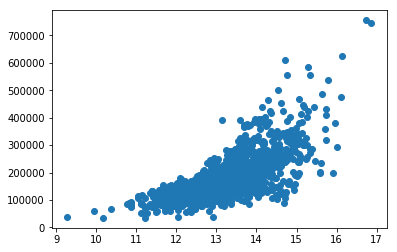

In [32]:
plt.scatter(x=train['GrLivArea'], y=y_train)

In [33]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train_log, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [34]:
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)

ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

In [35]:
lgb_params = {
               'feature_fraction': 0.75,
               'max_depth': 3,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

In [36]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.380969
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.354102
[3]	valid_0's rmse: 0.330125
[4]	valid_0's rmse: 0.310183
[5]	valid_0's rmse: 0.292301
[6]	valid_0's rmse: 0.276952
[7]	valid_0's rmse: 0.262158
[8]	valid_0's rmse: 0.250268
[9]	valid_0's rmse: 0.238612
[10]	valid_0's rmse: 0.228793
[11]	valid_0's rmse: 0.219292
[12]	valid_0's rmse: 0.210699
[13]	valid_0's rmse: 0.204215
[14]	valid_0's rmse: 0.197794
[15]	valid_0's rmse: 0.191428
[16]	valid_0's rmse: 0.186303
[17]	valid_0's rmse: 0.181064
[18]	valid_0's rmse: 0.177146
[19]	valid_0's rmse: 0.173617
[20]	valid_0's rmse: 0.170285
[21]	valid_0's rmse: 0.167435
[22]	valid_0's rmse: 0.164012
[23]	valid_0's rmse: 0.161227
[24]	valid_0's rmse: 0.15894
[25]	valid_0's rmse: 0.156861
[26]	valid_0's rmse: 0.154874
[27]	valid_0's rmse: 0.153533
[28]	valid_0's rmse: 0.15231
[29]	valid_0's rmse: 0.150514
[30]	valid_0's rmse: 0.148775
[31]	valid_0's rmse: 0.147142
[32]	valid_0's rms

[247]	valid_0's rmse: 0.109921
[248]	valid_0's rmse: 0.109899
[249]	valid_0's rmse: 0.109858
[250]	valid_0's rmse: 0.1098
[251]	valid_0's rmse: 0.109829
[252]	valid_0's rmse: 0.109893
[253]	valid_0's rmse: 0.110054
[254]	valid_0's rmse: 0.110019
[255]	valid_0's rmse: 0.110067
[256]	valid_0's rmse: 0.110049
[257]	valid_0's rmse: 0.110033
[258]	valid_0's rmse: 0.109843
[259]	valid_0's rmse: 0.109951
[260]	valid_0's rmse: 0.109941
[261]	valid_0's rmse: 0.109903
[262]	valid_0's rmse: 0.109846
[263]	valid_0's rmse: 0.109844
[264]	valid_0's rmse: 0.109825
[265]	valid_0's rmse: 0.109795
[266]	valid_0's rmse: 0.10979
[267]	valid_0's rmse: 0.109787
[268]	valid_0's rmse: 0.109769
[269]	valid_0's rmse: 0.109736
[270]	valid_0's rmse: 0.109832
[271]	valid_0's rmse: 0.109817
[272]	valid_0's rmse: 0.109816
[273]	valid_0's rmse: 0.109777
[274]	valid_0's rmse: 0.109728
[275]	valid_0's rmse: 0.109709
[276]	valid_0's rmse: 0.109707
[277]	valid_0's rmse: 0.109698
[278]	valid_0's rmse: 0.109588
[279]	valid

[252]	valid_0's rmse: 0.124462
[253]	valid_0's rmse: 0.124444
[254]	valid_0's rmse: 0.124452
[255]	valid_0's rmse: 0.124396
[256]	valid_0's rmse: 0.124411
[257]	valid_0's rmse: 0.124461
[258]	valid_0's rmse: 0.124432
[259]	valid_0's rmse: 0.124423
[260]	valid_0's rmse: 0.124382
[261]	valid_0's rmse: 0.124423
[262]	valid_0's rmse: 0.124385
[263]	valid_0's rmse: 0.124337
[264]	valid_0's rmse: 0.124305
[265]	valid_0's rmse: 0.124409
[266]	valid_0's rmse: 0.124432
[267]	valid_0's rmse: 0.124403
[268]	valid_0's rmse: 0.124419
[269]	valid_0's rmse: 0.124345
[270]	valid_0's rmse: 0.124337
[271]	valid_0's rmse: 0.124344
[272]	valid_0's rmse: 0.124389
[273]	valid_0's rmse: 0.124398
[274]	valid_0's rmse: 0.124398
[275]	valid_0's rmse: 0.124397
[276]	valid_0's rmse: 0.124408
[277]	valid_0's rmse: 0.124415
[278]	valid_0's rmse: 0.124316
[279]	valid_0's rmse: 0.124345
[280]	valid_0's rmse: 0.124299
[281]	valid_0's rmse: 0.124174
[282]	valid_0's rmse: 0.124192
[283]	valid_0's rmse: 0.124241
[284]	va

[296]	valid_0's rmse: 0.130253
[297]	valid_0's rmse: 0.130239
[298]	valid_0's rmse: 0.130281
[299]	valid_0's rmse: 0.130143
[300]	valid_0's rmse: 0.130199
[301]	valid_0's rmse: 0.130163
[302]	valid_0's rmse: 0.130238
[303]	valid_0's rmse: 0.130166
[304]	valid_0's rmse: 0.130195
[305]	valid_0's rmse: 0.130112
[306]	valid_0's rmse: 0.130144
[307]	valid_0's rmse: 0.130075
[308]	valid_0's rmse: 0.130067
[309]	valid_0's rmse: 0.130056
[310]	valid_0's rmse: 0.130024
[311]	valid_0's rmse: 0.130034
[312]	valid_0's rmse: 0.130057
[313]	valid_0's rmse: 0.130062
[314]	valid_0's rmse: 0.129982
[315]	valid_0's rmse: 0.129948
[316]	valid_0's rmse: 0.129982
[317]	valid_0's rmse: 0.129804
[318]	valid_0's rmse: 0.129729
[319]	valid_0's rmse: 0.129738
[320]	valid_0's rmse: 0.129668
[321]	valid_0's rmse: 0.129672
[322]	valid_0's rmse: 0.129687
[323]	valid_0's rmse: 0.12958
[324]	valid_0's rmse: 0.129547
[325]	valid_0's rmse: 0.129545
[326]	valid_0's rmse: 0.129612
[327]	valid_0's rmse: 0.129594
[328]	val

[157]	valid_0's rmse: 0.109237
[158]	valid_0's rmse: 0.109276
[159]	valid_0's rmse: 0.109224
[160]	valid_0's rmse: 0.109108
[161]	valid_0's rmse: 0.109275
[162]	valid_0's rmse: 0.109241
[163]	valid_0's rmse: 0.109224
[164]	valid_0's rmse: 0.109093
[165]	valid_0's rmse: 0.109187
[166]	valid_0's rmse: 0.109206
[167]	valid_0's rmse: 0.109181
[168]	valid_0's rmse: 0.109093
[169]	valid_0's rmse: 0.109106
[170]	valid_0's rmse: 0.1091
[171]	valid_0's rmse: 0.108924
[172]	valid_0's rmse: 0.109
[173]	valid_0's rmse: 0.10909
[174]	valid_0's rmse: 0.108988
[175]	valid_0's rmse: 0.108908
[176]	valid_0's rmse: 0.108862
[177]	valid_0's rmse: 0.108843
[178]	valid_0's rmse: 0.108709
[179]	valid_0's rmse: 0.109005
[180]	valid_0's rmse: 0.108982
[181]	valid_0's rmse: 0.108954
[182]	valid_0's rmse: 0.108949
[183]	valid_0's rmse: 0.108894
[184]	valid_0's rmse: 0.108814
[185]	valid_0's rmse: 0.108818
[186]	valid_0's rmse: 0.108802
[187]	valid_0's rmse: 0.10885
[188]	valid_0's rmse: 0.108838
[189]	valid_0's

In [37]:
val_rmse

[0.12317509153234167,
 0.1090381317203964,
 0.1228690929705746,
 0.12936627728293507,
 0.1082950041019852]

In [38]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance(importance_type='gain')

In [39]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

,Importance
TotalSF,339.739205
OverallQual,330.433211
GrLivArea,35.092136
YearRemodAdd,26.609589
YearBuilt,24.781826
GarageCars,18.268056
OverallCond,16.418032
CentralAir,13.732154
Fireplaces,13.419568
BsmtFinSF1,12.117835


In [40]:
explainerLGB = shap.TreeExplainer(reg[-1])
shap_values_LGB_test = explainerLGB.shap_values(X_val)
shap_values_LGB_train = explainerLGB.shap_values(X_tr)

df_shap_LGB_test = pd.DataFrame(shap_values_LGB_test, columns=X_val.columns.values)
df_shap_LGB_train = pd.DataFrame(shap_values_LGB_train, columns=X_tr.columns.values)

In [55]:
# j will be the record we explain
j = 1

In [42]:
# initialize js for SHAP
shap.initjs()

In [56]:
shap.force_plot(explainerLGB.expected_value, shap_values_LGB_test[j], X_val.iloc[[j]])

In [44]:
pred_lgb[20]

12.344824285640678

In [45]:
y_val[20]

12.328290278254423

In [46]:
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_tr.values[:,x])) for x in range(X_tr.values.shape[1])]) <= 10).flatten()
 
# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(X_tr.values, feature_names=X_tr.columns.values.tolist(), class_names=['price'], 
                                                   categorical_features=categorical_features, verbose=True, mode='regression')

In [47]:
expLGB = explainer.explain_instance(X_val.values[j], reg[-1].predict, num_features=5)
expLGB.show_in_notebook(show_table=True) 

Intercept 11.889429651103768
Prediction_local [12.29793499]
Right: 12.344824285640678


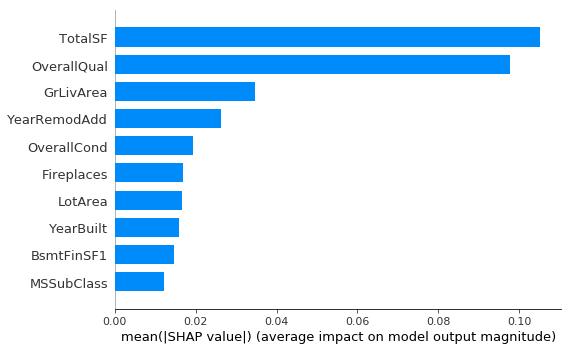

In [52]:
shap.summary_plot(shap_values_LGB_train, X_tr, plot_type="bar", max_display=10)

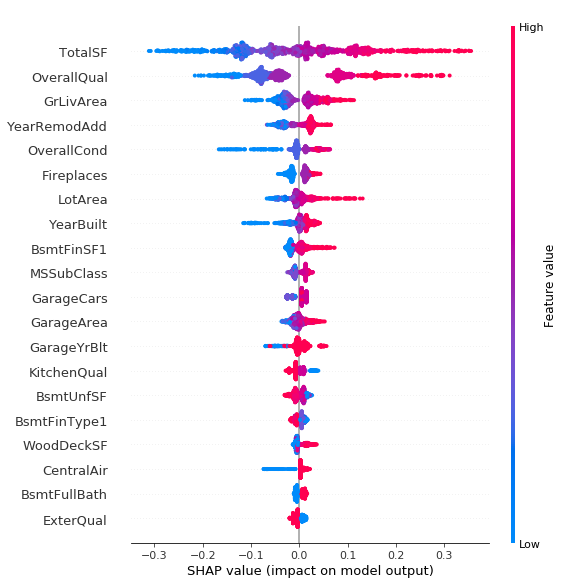

In [49]:
shap.summary_plot(shap_values_LGB_train, X_tr)

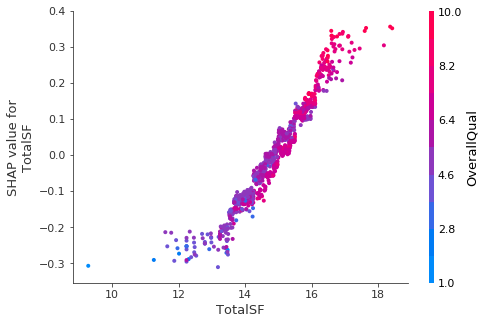

In [50]:
shp_plt = shap.dependence_plot("TotalSF", shap_values_LGB_train, X_tr)

In [52]:
dropf = importance[importance['Importance']==0].index
train = train.drop(dropf, axis=1)
test = test.drop(dropf, axis=1)

In [53]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.380969
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.355616
[3]	valid_0's rmse: 0.332818
[4]	valid_0's rmse: 0.311374
[5]	valid_0's rmse: 0.293649
[6]	valid_0's rmse: 0.277187
[7]	valid_0's rmse: 0.262305
[8]	valid_0's rmse: 0.249915
[9]	valid_0's rmse: 0.239692
[10]	valid_0's rmse: 0.228833
[11]	valid_0's rmse: 0.219604
[12]	valid_0's rmse: 0.210604
[13]	valid_0's rmse: 0.203258
[14]	valid_0's rmse: 0.196632
[15]	valid_0's rmse: 0.190472
[16]	valid_0's rmse: 0.184758
[17]	valid_0's rmse: 0.180965
[18]	valid_0's rmse: 0.176487
[19]	valid_0's rmse: 0.172895
[20]	valid_0's rmse: 0.168829
[21]	valid_0's rmse: 0.165356
[22]	valid_0's rmse: 0.162586
[23]	valid_0's rmse: 0.160059
[24]	valid_0's rmse: 0.158018
[25]	valid_0's rmse: 0.155232
[26]	valid_0's rmse: 0.153713
[27]	valid_0's rmse: 0.151519
[28]	valid_0's rmse: 0.150016
[29]	valid_0's rmse: 0.148742
[30]	valid_0's rmse: 0.147448
[31]	valid_0's rmse: 0.145599
[32]	valid_0's r

[48]	valid_0's rmse: 0.123675
[49]	valid_0's rmse: 0.123396
[50]	valid_0's rmse: 0.122917
[51]	valid_0's rmse: 0.122578
[52]	valid_0's rmse: 0.122267
[53]	valid_0's rmse: 0.121662
[54]	valid_0's rmse: 0.121306
[55]	valid_0's rmse: 0.12081
[56]	valid_0's rmse: 0.120494
[57]	valid_0's rmse: 0.120285
[58]	valid_0's rmse: 0.119969
[59]	valid_0's rmse: 0.11955
[60]	valid_0's rmse: 0.119275
[61]	valid_0's rmse: 0.119077
[62]	valid_0's rmse: 0.118901
[63]	valid_0's rmse: 0.118723
[64]	valid_0's rmse: 0.118418
[65]	valid_0's rmse: 0.118116
[66]	valid_0's rmse: 0.117832
[67]	valid_0's rmse: 0.117712
[68]	valid_0's rmse: 0.117476
[69]	valid_0's rmse: 0.117386
[70]	valid_0's rmse: 0.117315
[71]	valid_0's rmse: 0.117265
[72]	valid_0's rmse: 0.117048
[73]	valid_0's rmse: 0.116908
[74]	valid_0's rmse: 0.116674
[75]	valid_0's rmse: 0.116554
[76]	valid_0's rmse: 0.11627
[77]	valid_0's rmse: 0.116089
[78]	valid_0's rmse: 0.116089
[79]	valid_0's rmse: 0.115878
[80]	valid_0's rmse: 0.115799
[81]	valid_0'

[347]	valid_0's rmse: 0.110189
[348]	valid_0's rmse: 0.110244
[349]	valid_0's rmse: 0.110183
[350]	valid_0's rmse: 0.110131
[351]	valid_0's rmse: 0.110157
[352]	valid_0's rmse: 0.110224
[353]	valid_0's rmse: 0.110156
[354]	valid_0's rmse: 0.11015
[355]	valid_0's rmse: 0.110112
[356]	valid_0's rmse: 0.110126
[357]	valid_0's rmse: 0.11016
[358]	valid_0's rmse: 0.110155
[359]	valid_0's rmse: 0.110091
[360]	valid_0's rmse: 0.110091
[361]	valid_0's rmse: 0.110066
[362]	valid_0's rmse: 0.11007
[363]	valid_0's rmse: 0.110077
[364]	valid_0's rmse: 0.110033
[365]	valid_0's rmse: 0.110014
[366]	valid_0's rmse: 0.110007
[367]	valid_0's rmse: 0.109996
[368]	valid_0's rmse: 0.109999
[369]	valid_0's rmse: 0.110011
[370]	valid_0's rmse: 0.109985
[371]	valid_0's rmse: 0.109944
[372]	valid_0's rmse: 0.109851
[373]	valid_0's rmse: 0.109874
[374]	valid_0's rmse: 0.109884
[375]	valid_0's rmse: 0.109812
[376]	valid_0's rmse: 0.109777
[377]	valid_0's rmse: 0.109755
[378]	valid_0's rmse: 0.109869
[379]	valid

[297]	valid_0's rmse: 0.124403
[298]	valid_0's rmse: 0.124335
[299]	valid_0's rmse: 0.124302
[300]	valid_0's rmse: 0.124309
[301]	valid_0's rmse: 0.124255
[302]	valid_0's rmse: 0.124282
[303]	valid_0's rmse: 0.124256
[304]	valid_0's rmse: 0.124152
[305]	valid_0's rmse: 0.12414
[306]	valid_0's rmse: 0.124072
[307]	valid_0's rmse: 0.124053
[308]	valid_0's rmse: 0.124101
[309]	valid_0's rmse: 0.124139
[310]	valid_0's rmse: 0.124117
[311]	valid_0's rmse: 0.124071
[312]	valid_0's rmse: 0.124071
[313]	valid_0's rmse: 0.124055
[314]	valid_0's rmse: 0.124004
[315]	valid_0's rmse: 0.123899
[316]	valid_0's rmse: 0.123882
[317]	valid_0's rmse: 0.123923
[318]	valid_0's rmse: 0.123826
[319]	valid_0's rmse: 0.123808
[320]	valid_0's rmse: 0.123793
[321]	valid_0's rmse: 0.123692
[322]	valid_0's rmse: 0.123657
[323]	valid_0's rmse: 0.123645
[324]	valid_0's rmse: 0.123621
[325]	valid_0's rmse: 0.123519
[326]	valid_0's rmse: 0.123503
[327]	valid_0's rmse: 0.123543
[328]	valid_0's rmse: 0.123553
[329]	val

[299]	valid_0's rmse: 0.131308
[300]	valid_0's rmse: 0.131391
[301]	valid_0's rmse: 0.131418
[302]	valid_0's rmse: 0.131338
[303]	valid_0's rmse: 0.131352
[304]	valid_0's rmse: 0.131334
[305]	valid_0's rmse: 0.13139
[306]	valid_0's rmse: 0.131459
[307]	valid_0's rmse: 0.131508
[308]	valid_0's rmse: 0.131534
[309]	valid_0's rmse: 0.131484
[310]	valid_0's rmse: 0.131335
[311]	valid_0's rmse: 0.131391
[312]	valid_0's rmse: 0.131491
[313]	valid_0's rmse: 0.13137
[314]	valid_0's rmse: 0.131275
[315]	valid_0's rmse: 0.131261
[316]	valid_0's rmse: 0.131148
[317]	valid_0's rmse: 0.131072
[318]	valid_0's rmse: 0.131106
[319]	valid_0's rmse: 0.131053
[320]	valid_0's rmse: 0.131119
[321]	valid_0's rmse: 0.131046
[322]	valid_0's rmse: 0.131013
[323]	valid_0's rmse: 0.131015
[324]	valid_0's rmse: 0.13099
[325]	valid_0's rmse: 0.130999
[326]	valid_0's rmse: 0.131019
[327]	valid_0's rmse: 0.131045
[328]	valid_0's rmse: 0.131085
[329]	valid_0's rmse: 0.131077
[330]	valid_0's rmse: 0.131033
[331]	valid

[294]	valid_0's rmse: 0.112421
[295]	valid_0's rmse: 0.112415
[296]	valid_0's rmse: 0.112429
[297]	valid_0's rmse: 0.112433
[298]	valid_0's rmse: 0.112463
[299]	valid_0's rmse: 0.112528
[300]	valid_0's rmse: 0.112584
[301]	valid_0's rmse: 0.112789
[302]	valid_0's rmse: 0.112803
[303]	valid_0's rmse: 0.112745
[304]	valid_0's rmse: 0.112769
[305]	valid_0's rmse: 0.112757
[306]	valid_0's rmse: 0.112715
[307]	valid_0's rmse: 0.112691
[308]	valid_0's rmse: 0.11271
[309]	valid_0's rmse: 0.112765
[310]	valid_0's rmse: 0.112686
[311]	valid_0's rmse: 0.112695
[312]	valid_0's rmse: 0.112837
[313]	valid_0's rmse: 0.112874
[314]	valid_0's rmse: 0.112791
[315]	valid_0's rmse: 0.112856
[316]	valid_0's rmse: 0.112849
[317]	valid_0's rmse: 0.112962
[318]	valid_0's rmse: 0.113008
[319]	valid_0's rmse: 0.113046
[320]	valid_0's rmse: 0.113097
[321]	valid_0's rmse: 0.113087
[322]	valid_0's rmse: 0.113155
[323]	valid_0's rmse: 0.113241
[324]	valid_0's rmse: 0.113291
[325]	valid_0's rmse: 0.113318
[326]	val

In [54]:
np.sum(val_rmse)/n_folds

0.11970958193386212

In [55]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [56]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

,Importance
LotArea,107.8
TotalSF,100.0
GrLivArea,84.0
GarageArea,69.6
1stFlrSF,67.4
YearBuilt,66.8
GarageYrBlt,62.0
BsmtUnfSF,61.6
OverallCond,55.2
OverallQual,54.8


feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance(importance_type='gain')

importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

In [57]:
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = -1,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(train_ss, y_train_log)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

0.11067105750623023
{'gamma': 0.0001, 'epsilon': 0.0001, 'C': 100}


In [58]:
preds_svr = svr.predict(test_ss)

drop_f2 = importance[importance['Importance']==0].index

for df in [train, test]:
    df = df.drop(drop_f2, axis=1)

train = train.drop(drop_f2, axis=1)

test = test.drop(dropf, axis=1)
test = test.drop(drop_f2, axis=1)

In [59]:
reg_lasso = []
val_rmse_lasso = []

ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.001).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

0.11387309579674901


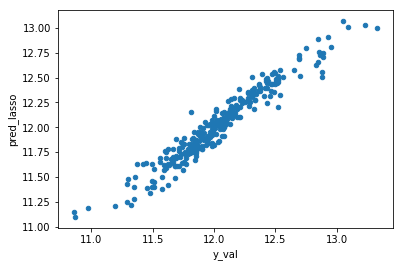

In [60]:
predictions = pd.DataFrame({"y_val":y_val, "pred_lasso":pred_lasso})
predictions.plot(x = "y_val", y = "pred_lasso", kind = "scatter")

In [61]:
preds_lasso = None

for model in reg_lasso:
    if preds_lasso is None:
        preds_lasso = model.predict(test_ss) / n_folds
    else:
        preds_lasso += model.predict(test_ss) / n_folds

In [62]:
preds_lgb = None

for model in reg:
    if preds_lgb is None:
        preds_lgb = model.predict(test) / n_folds
    else:
        preds_lgb += model.predict(test) / n_folds

In [64]:
preds = np.exp(preds_svr*0.5 + preds_lasso*0.3 + preds_lgb*0.2)

preds = None

for model in reg:
    if preds is None:
        preds = model.predict(test) / n_folds
    else:
        preds += model.predict(test) / n_folds

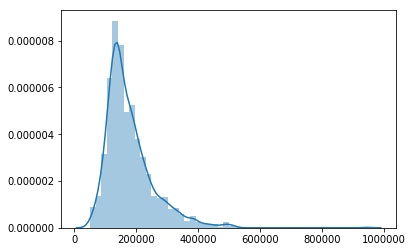

In [65]:
sns.distplot(preds)

In [67]:
solution = pd.DataFrame({"id":test_id, "SalePrice":preds})
solution.to_csv("submission_44.csv", index = False)